In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import kapre
import keras
import os
import soundfile as sf
import time
import progressbar
import gc
import h5py

Using TensorFlow backend.


In [2]:
# Load metadata to extract labels
metadata = pd.read_csv('/data/music/musicnet/metadata.csv')

In [3]:
metadata.head()

id  composer               composition                   movement  \
0  1727  Schubert  Piano Quintet in A major                 2. Andante   
1  1728  Schubert  Piano Quintet in A major         3. Scherzo: Presto   
2  1729  Schubert  Piano Quintet in A major  4. Andantino - Allegretto   
3  1730  Schubert  Piano Quintet in A major          5. Allegro giusto   
4  1733  Schubert   Piano Sonata in A major               2. Andantino   

        ensemble            source                      transcriber  \
0  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
1  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
2  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
3  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
4     Solo Piano          Museopen                Segundo G. Yogore   

  catalog_name  seconds  
0        OP114      447  
1        OP114      251  
2        OP114      444  
3        OP114      368  
4         D959      546

In [4]:
# Construct a dictionary id --> composer, which will be used later to set the labels for all sound snippets
composers = pd.Series(metadata.composer.values,index=metadata.id).to_dict()
examples = [1755, 2211, 2368]
[composers.get(example) for example in examples]

['Schubert', 'Bach', 'Beethoven']

In [5]:
# Creating dataset
# First we define a function to load the audio snippets and to create the labels
def load_audio(path, downsampling_rate, duration_sec, composers):
        '''Requires the soundfile package, imported as sf '''
        files = os.listdir(path)
        message = "Processing {0} audio files...".format(len(files))
        print(message)
        message = "Downsampling dataset to {0}% (equivalent to {1} audio files).".format(downsampling_rate*100, int(downsampling_rate * len(files)) )
        print(message)
        
        ds = np.random.choice(files, int(len(files) * downsampling_rate), replace=False)
        
        # Initialise empty arrays
        data = np.zeros((len(ds), 1, 88200))
        labels = np.zeros(len(ds), dtype = "<U10")
        
        with progressbar.ProgressBar(max_value=len(ds)) as bar:
            
            for i, file in enumerate(ds):
                # load and process file, then add to array
                audio_clip, sr = sf.read(path + file)
                audio_clip = audio_clip[:int(sr*duration_sec)]
                audio_clip = audio_clip[np.newaxis, :]
                data[i, :audio_clip.shape[0],:audio_clip.shape[1]] = audio_clip
                audio_clip = None
            
                # look up label and add to array
                file_id = file.split("-")[0]
                label = composers[int(file_id)]
                labels[i] = label 
                label = None
                bar.update(i)
            
        return labels, data
        

In [ ]:
# These sections can be skipped as there's no need to re-create these variables:
# they can be loaded from disk.
#
# Load audio files, process them and create dataset and labels
labels, data = load_audio("/data/music/musicnet/data_chunks/", 0.5, 2, composers)

In [ ]:
# Turn labels to categorical (one-hot encoding)
labels_pd = pd.DataFrame(labels)
onehot = pd.get_dummies(labels_pd)
targets = onehot.as_matrix()
targets.shape

In [ ]:
# Store datasets as hdf5 files
all_data = h5py.File('/data/music/musicnet/hdf5/data.hdf5', 'w')
all_data.create_dataset('data', data=data)
all_data.create_dataset('targets', data=targets)
all_data.close()

In [ ]:
# Remove variables and release all memory
data = None
targets = None
gc.collect()

In [ ]:
# Create training, validation and test datasets
all_data = h5py.File('/data/music/musicnet/hdf5/data.hdf5', 'r')
list(all_data.keys())
data = all_data['data']
targets = all_data['targets']

In [ ]:
# Get indices for random sampling of datasets
indices = np.random.permutation(data.shape[0])
training_test_split = 0.8
size_training_bf_validation = int(len(indices) * training_test_split)
training_validation_split = 0.8
size_training = int(size_training_bf_validation * training_validation_split)
size_validation = size_training_bf_validation - size_training
size_test = len(indices) - size_training - size_validation

training_idx = indices[:size_training]
validation_idx = indices[size_training:(size_training+size_validation)]
test_idx = indices[(size_training+size_validation):(size_training+size_validation+size_test)]

In [ ]:
# Generate each dataset, save as hdf5 and release memory

In [ ]:
# Training
training_data = data[np.sort(training_idx),:]
training_targets = targets[np.sort(training_idx),:]

In [ ]:
training = h5py.File('/data/music/musicnet/hdf5/training.hdf5', 'w')
training.create_dataset('data', data=training_data)
training.create_dataset('targets', data=training_targets)
training.close()

In [ ]:
training_data = None
training_targets = None
gc.collect()

In [ ]:
# Validatation
validation_data = data[np.sort(validation_idx),:]
validation_targets = targets[np.sort(validation_idx),:]

In [ ]:
validation = h5py.File('/data/music/musicnet/hdf5/validation.hdf5', 'w')
validation.create_dataset('data', data=validation_data)
validation.create_dataset('targets', data=validation_targets)
validation.close()

In [ ]:
validation_data = None
validation_targets = None
gc.collect()

In [ ]:
# Test
test_data = data[np.sort(test_idx),:]
test_targets = targets[np.sort(test_idx),:]

In [ ]:
test = h5py.File('/data/music/musicnet/hdf5/test.hdf5', 'w')
test.create_dataset('data', data=test_data)
test.create_dataset('targets', data=test_targets)
test.close()

In [ ]:
test_data = None
test_targets = None
data = None
targets = None
training = None
validation = None
test = None
gc.collect()

In [ ]:
# CONVOLUTIONAL NETWORK

In [6]:
# Define a model whose first layer is a mel-spectrogram (from Kapre)
from keras.models import Sequential
from keras import layers
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

In [7]:
# Code inspired by https://github.com/keunwoochoi/kapre
input_shape = (1, 88200)
sr = 44100

model = Sequential()
# A mel-spectrogram layer
model.add(Melspectrogram(n_dft=512, n_hop=256, input_shape=input_shape,
                         padding='same', sr=sr, n_mels=64,
                         fmin=0.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=False, trainable_fb=False,
                         trainable_kernel=False,
                         name='trainable_stft'))
# Add some white noise
model.add(AdditiveNoise(power=0.2))
# Normalise it per-frequency
model.add(Normalization2D(str_axis='batch')) # or 'channel', 'time', 'batch', 'data_sample'
# Add convolution layers
model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

In [8]:
# Load the training and validation data from hdf5
training = h5py.File('/data/music/musicnet/hdf5/training.hdf5', 'r')
validation = h5py.File('/data/music/musicnet/hdf5/validation.hdf5', 'r')

list(training.keys())
training_data = training['data']
training_targets = training['targets']

list(validation.keys())
validation_data = validation['data']
validation_targets = validation['targets']

In [9]:
# Compile model
from keras import optimizers
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
#model.summary()

In [11]:
file_path="/home/ubuntu/code/trained_model/music/music-weights-improvement-{epoch:02d}-{val_loss:.4f}-{val_acc:.2f}.hdf5"

callbacks_list = [
        #keras.callbacks.EarlyStopping(monitor='acc', patience=2,),
        keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='val_loss', save_best_only=True,),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7,)]

history = model.fit(training_data, 
                    training_targets,
                    epochs = 100,
                    batch_size = 150,
                    callbacks=callbacks_list,
                    validation_data=(validation_data, validation_targets),
                    shuffle=False)

Train on 19710 samples, validate on 4928 samples
Epoch 1/100
19710/19710 [==============================] - 50s 3ms/step - loss: 1.5808 - acc: 0.5276 - val_loss: 1.6594 - val_acc: 0.5244
Epoch 2/100
19710/19710 [==============================] - 45s 2ms/step - loss: 1.5221 - acc: 0.5304 - val_loss: 1.5757 - val_acc: 0.5256
Epoch 3/100
19710/19710 [==============================] - 45s 2ms/step - loss: 1.4677 - acc: 0.5348 - val_loss: 1.4921 - val_acc: 0.5422
Epoch 4/100
19710/19710 [==============================] - 45s 2ms/step - loss: 1.3993 - acc: 0.5447 - val_loss: 1.4655 - val_acc: 0.5465
Epoch 5/100
19710/19710 [==============================] - 45s 2ms/step - loss: 1.3499 - acc: 0.5517 - val_loss: 1.4380 - val_acc: 0.5406
Epoch 6/100
19710/19710 [==============================] - 45s 2ms/step - loss: 1.3091 - acc: 0.5562 - val_loss: 1.4073 - val_acc: 0.5349
Epoch 7/100
19710/19710 [==============================] - 45s 2ms/step - loss: 1.2727 - acc: 0.5663 - val_loss: 1.4089 - v

19710/19710 [==============================] - 45s 2ms/step - loss: 0.9819 - acc: 0.6481 - val_loss: 1.3504 - val_acc: 0.5700
Epoch 60/100
19710/19710 [==============================] - 45s 2ms/step - loss: 0.9820 - acc: 0.6455 - val_loss: 1.3504 - val_acc: 0.5700
Epoch 61/100
19710/19710 [==============================] - 45s 2ms/step - loss: 0.9876 - acc: 0.6440 - val_loss: 1.3504 - val_acc: 0.5700
Epoch 62/100
19710/19710 [==============================] - 45s 2ms/step - loss: 0.9841 - acc: 0.6486 - val_loss: 1.3504 - val_acc: 0.5700
Epoch 63/100
19710/19710 [==============================] - 45s 2ms/step - loss: 0.9875 - acc: 0.6471 - val_loss: 1.3504 - val_acc: 0.5700
Epoch 64/100
19710/19710 [==============================] - 45s 2ms/step - loss: 0.9835 - acc: 0.6453 - val_loss: 1.3504 - val_acc: 0.5700
Epoch 65/100
19710/19710 [==============================] - 45s 2ms/step - loss: 0.9820 - acc: 0.6506 - val_loss: 1.3504 - val_acc: 0.5700
Epoch 66/100
19710/19710 [==============

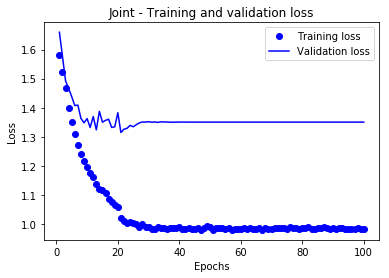

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Total Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Joint - Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

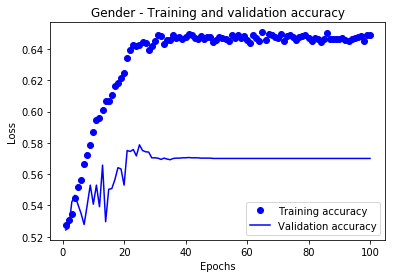

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.subplots(1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Gender - Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Do test predictions and compare performance with baseline
test = h5py.File('/data/music/musicnet/hdf5/test.hdf5', 'r')

list(test.keys())
test_data = test['data']
test_targets = test['targets']

OSError: Unable to open file (unable to open file: name = '/data/music/musicnet/hdf5/test.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
test_predictions = model.predict(test_data)

In [ ]:
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_target_labels = np.argmax(test_targets, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
print('Accuracy ', accuracy_score(test_target_labels, test_predicted_labels))
print(classification_report(test_target_labels, test_predicted_labels))

In [ ]:
# Compare with baseline classifier (in this case we pick the most popular class)
most_popular = np.argmax(np.bincount(test_target_labels))

In [ ]:
baseline_prediction = np.repeat(most_popular, test_target_labels.shape[0])

In [ ]:
print('Accuracy ', accuracy_score(test_target_labels, baseline_prediction))
print(classification_report(test_target_labels, baseline_prediction))